# Task 1 Canny Edge Detector
## Task 1.1 Canny Filter from CV

In [1]:
import numpy as np
from PIL import Image, ImageFilter
import cv2 as cv
import matplotlib.pyplot as plt
from scipy import stats
import argparse
import os
import rawpy

In [2]:
def load_nef(path):
    with rawpy.imread(path) as raw:
        img = raw.postprocess()
    return img

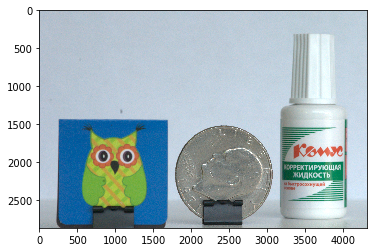

In [3]:
image_ref=load_nef('img/DVD_2087.NEF')
image_middle=load_nef('img/DVD_2088.NEF')
image_far=load_nef('img/DVD_2089.NEF')
image_nea=load_nef('img/DVD_2090.NEF')
images=[image_ref,image_middle,image_far,image_nea]
plt.imshow(images[0])

In [4]:
edges_reference = cv.Canny(images[0],100,185,L2gradient=True)
edges_middle = cv.Canny(images[1],100,185,L2gradient=True)
edges_far = cv.Canny(images[2],100,185,L2gradient=True)
edges_near = cv.Canny(images[3],100,185,L2gradient=True)

Eadges=[edges_reference,edges_middle,edges_far,edges_near]

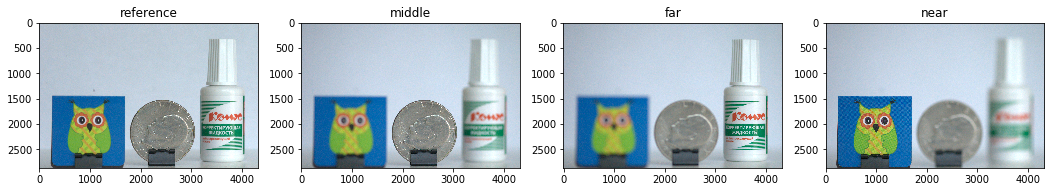

In [5]:
labels=['reference','middle','far','near']
fig, axes = plt.subplots(
ncols=4,
nrows=1,figsize=(18,12))
for img, ax,label in zip(images, axes.flat,labels):
    ax.imshow(img,cmap='gray')
    ax.set_title(label)

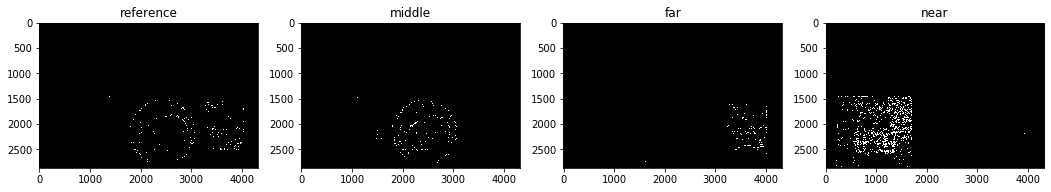

In [6]:
labels=['reference','middle','far','near']
fig, axes = plt.subplots(
ncols=4,
nrows=1,figsize=(18,12))
for img, ax,label in zip(Eadges, axes.flat,labels):
    ax.imshow(img,cmap='gray')
    ax.set_title(label)

### We will be use structural similarity index

In [7]:
from skimage.measure import compare_ssim as ssim
for img, eadge,label in zip(images,Eadges,labels):
    print(str(label),ssim(cv.cvtColor(np.array(img), cv.COLOR_RGB2GRAY),eadge))

reference 0.0009659096091683093
middle 0.000941750940856806
far 0.0005262187332355379
near 0.000844700517823347


## Task 1.2

In [3]:
#Gaussian filter
#references: https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
from scipy.ndimage import gaussian_filter

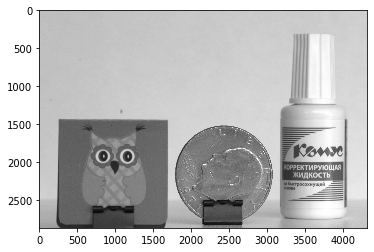

In [10]:
a=cv.cvtColor(np.array(images[0]), cv.COLOR_BGR2GRAY)
r=gaussian_filter(a,0.5)
plt.imshow(r,cmap='gray')

### Gradient calculation

In [4]:

from scipy import ndimage
def sobel_filters(img):
    Kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    Ix = np.real(np.fft.ifft2(np.fft.fft2(Kernel_x, s=img.shape) * np.fft.fft2(img)))
    Iy = np.real(np.fft.ifft2(np.fft.fft2(Kernel_y, s=img.shape) * np.fft.fft2(img)))

    
    G = np.sqrt(Ix**2+Iy**2)

    theta = np.arctan2(Iy, Ix)
    
    return G, theta

In [12]:
a,b=sobel_filters(r)

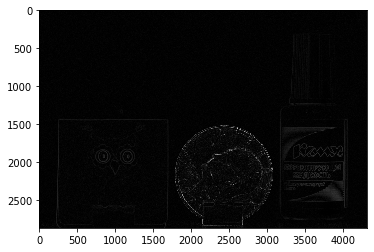

In [13]:
plt.imshow(a,cmap='gray')

### non-maximum suppression

In [5]:
def non_max_suppression(img, D):
    Z = np.zeros((img.shape[0],img.shape[1]), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,img.shape[0]-1):
        for j in range(1,img.shape[1]-1):
            try:
                q = 255
                r = 255

                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]

                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

              
                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0
                

            except IndexError as e:
                pass
    
    return Z

In [15]:
fk=non_max_suppression(a,b)

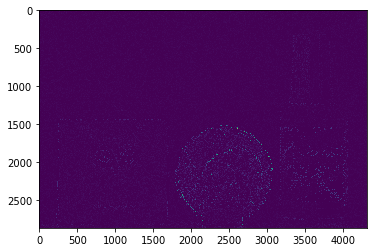

In [16]:
plt.imshow(fk)

In [6]:
def double_threshold(img, lowRatio, highRatio):
    
    highThreshold = np.max(img) * highRatio;
    lowThreshold = highThreshold * lowRatio;
    
    res = np.zeros((img.shape[0],img.shape[1]))
    
    strong_row, strong_col = np.where(img >= highThreshold)
    zeros_row, zeros_col = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_row, strong_col] = 255
    res[weak_i, weak_j] = 25
    
    return res

In [18]:
dd=double_threshold(fk,0.05,0.09)

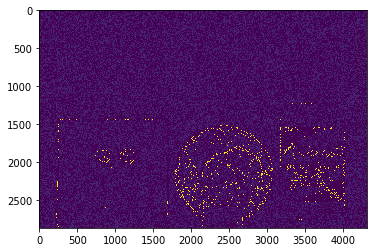

In [19]:
plt.imshow(dd)

In [7]:
def hysteresis(img):
    for i in range(1, img.shape[0]-1):
        for j in range(1, img.shape[1] -1):
            if (img[i,j] == 25):
                try:
                    if ((img[i+1, j-1] == 255) or (img[i+1, j] == 255) or (img[i+1, j+1] == 255)
                        or (img[i, j-1] == 255) or (img[i, j+1] == 255)
                        or (img[i-1, j-1] == 255) or (img[i-1, j] == 255) or (img[i-1, j+1] == 255)):
                        img[i, j] = 255
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

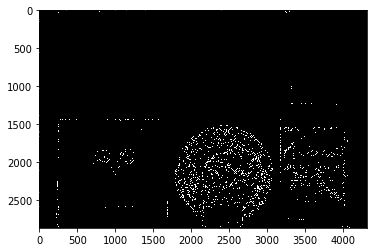

In [21]:
g=hysteresis(dd)
plt.imshow(g,cmap='gray')

In [8]:
def my_Canny_func(image,sigma,lowRatio,highRatio):
    a=cv.cvtColor(np.array(image), cv.COLOR_BGR2GRAY)
    gauss=gaussian_filter(a,sigma)
    gradient,angles=sobel_filters(gauss)
    supression=non_max_suppression(gradient,angles)
    threshold=double_threshold(supression,lowRatio,highRatio)
    result=hysteresis(threshold)
    return result

In [23]:
my_Canny=my_Canny_func(images[0],0.5,0.05,0.09)

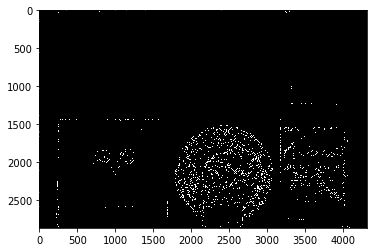

In [24]:
plt.imshow(my_Canny,cmap='gray')

# Task 2 Real-time video

In [9]:

video_capture = cv.VideoCapture(0)
while True:
    ret, frame = video_capture.read()
    if ret:
        cv.imshow('My_Video', frame)
        k = cv.waitKey(33)
        if  k == 27: 
            break
    else:
        break
video_capture.release()
cv.destroyAllWindows()

In [24]:
photo=Image.open('img/Nikolay.png')

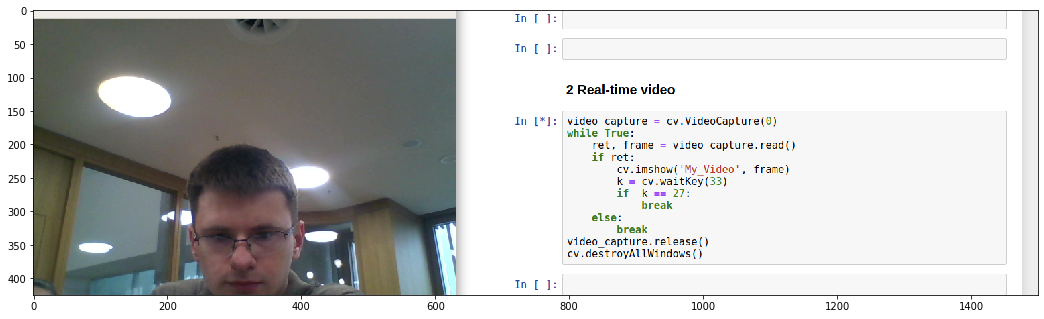

In [48]:
plt.figure(figsize=(18,6))
plt.imshow(photo)

### Canny filters on the live video stream

highRatio
t-increase
y-decrease

lowRatio
i-increase
o-decrease

In [41]:
print(ord('t'))
print(ord('y'))
print(ord('i'))
print(ord('o'))

116
121
105
111


In [11]:
video_capture = cv.VideoCapture(0)
lowRatio=0.05
highRatio=0.09
low_open=100
high_open=185
while True:
    ret, frame = video_capture.read()
    open_cv=cv.Canny(frame,100,185)
    my_canny=my_Canny_func(frame,0.5,lowRatio,highRatio)
    high= cv.waitKey(33)
    low= cv.waitKey(33)
    if ret:
        if high==116:
            highRatio+=0.01
            high_open+=1
        if high==121:
            highRatio-=0.01
            high_open-=1
            
        if low==105:
            lowRatio+=0.01
            low_open+=1
        if low==111:
            lowRatio-=0.01
            low_open-=1
        else:
            highRatio=highRatio
            lowRatio=lowRatio
            
                
        cv.imshow('Video', frame)
        cv.imshow('open_cv', open_cv)
        cv.imshow('my_canny', my_canny.astype('uint8'))
        k = cv.waitKey(33)
        if  k == 27: 
            break
    else:
        break
video_capture.release()
cv.destroyAllWindows()

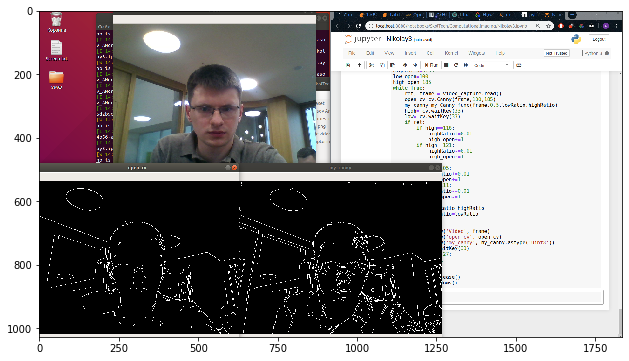

In [49]:
photo_new=Image.open('img/me_new.png')
plt.figure(figsize=(18,6))
plt.imshow(photo_new)

here we can see from one side that custom made canny algorithm add some aditional noise, but from another side edges more expressed 

## Task Z-stack of DoF dataset images